In [1]:
#################################################################################
# This tuitoral performs basic data processing and data analysis for dataset using seurat
# refer to https://satijalab.org/seurat/ Vignette "Guided tutorial"
# Please modify this script to apply for specific dataset.
# Usage: Rscript HCA-d_data_processing_seurat.r datasetName dataFormat
# Usage example: Rscript HCA-d_data_processing_seurat.r spleen_spleen_Madissoon2019 10X
#################################################################################

In [1]:
datasetName = 'BoneMarrow_BoneMarrow_HCLAdult-Bone-Marrow2'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/home/bianhaiyang/hcad/hcl/hcl_all/BoneMarrow_BoneMarrow_HCLAdult-Bone-Marrow2")
library(Seurat)
library(data.table)
library(ggplot2)
#library(flexclust)
#install.packages('flexclust')

In [2]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [3]:
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"

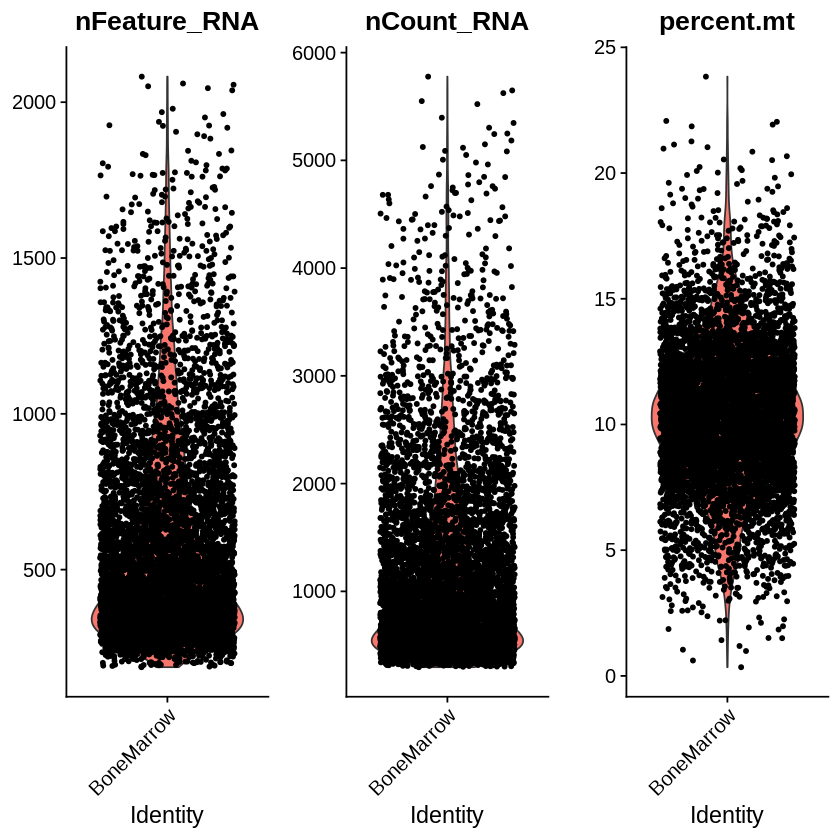

In [4]:
# Visualize QC metrics as a violin plot
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

## 下面要调

In [5]:
# Pre-processing
min.cells = 3
min.features = 0
nFeature_RNA_range = c(0, 6000)
percent.mt.thre = 25

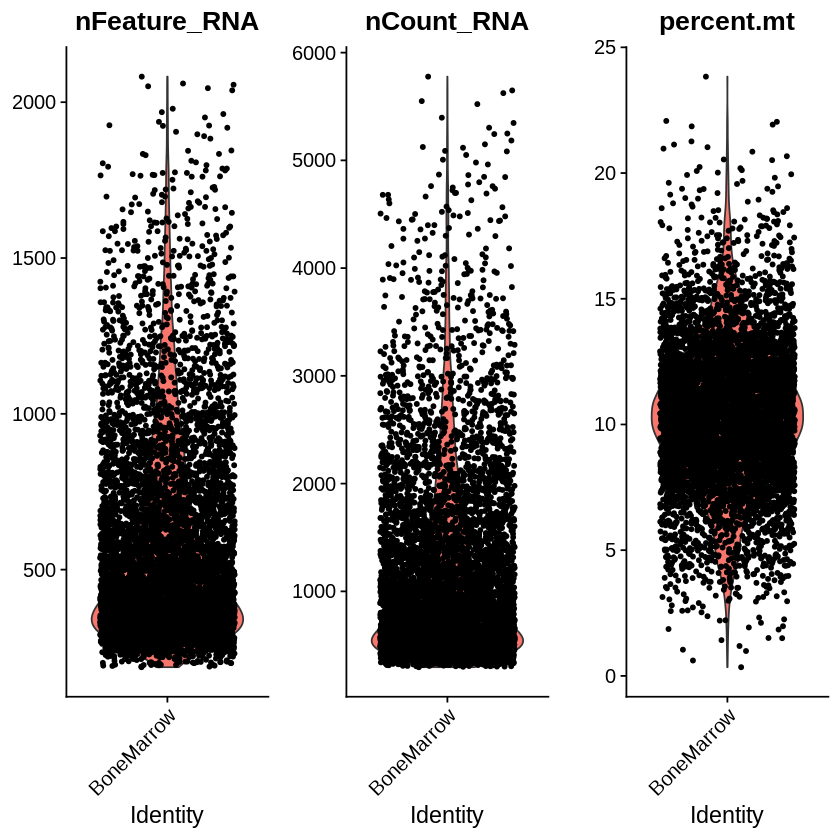

In [6]:
# QC
#dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
# Visualize QC metrics as a violin plot
VlnPlot(dataobj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)#+scale_color_npg() 不起作用

In [7]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()


PC_ 1 
Positive:  RNASE2, LYZ, SRGN, CD24, MS4A3, PLAC8, TMSB4X, VIM, FCN1, S100P 
	   BPI, DEFA3, FCER1G, AZU1, PGLYRP1, SERPINB1, CEACAM8, ANXA3, RETN, RNASE3 
	   CEACAM6, SLPI, DEFA4, NKG7, MPO, LTF, CST7, CRISP3, LCN2, ELANE 
Negative:  HBB, AHSP, CA1, FTH1, PRDX2, BLVRB, HBD, TFRC, HBA1, UROD 
	   IFI27, GYPA, ATPIF1, HMBS, TMEM14B, TMEM14C, CA2, HBA2, RHAG, REXO2 
	   RAN, SOD1, MPC2, S100A6, SLIRP, AKR1C3, HSPE1, GYPB, RFESD, FBXO7 
PC_ 2 
Positive:  HBA2, HBM, HBA1, SLC4A1, GYPB, GYPA, HEMGN, HBD, ALAS2, CA1 
	   HBB, AHSP, CA2, SLC25A37, HMBS, MGST3, RHCE, H1F0, PGLYRP1, PRDX2 
	   LTF, AQP1, IFI27, GYPE, CRISP3, LCN2, MMP8, TSPO2, CAMP, BLVRB 
Negative:  MIF, GAPDH, TMSB10, PTMA, LDHB, NPM1, MPO, B2M, PRSS57, PRTN3 
	   NUCB2, HSP90AB1, CTSG, ELANE, FABP5, PEBP1, HSPE1, BEX3, HSP90B1, CALR 
	   FTL, HSPA5, CST7, MGST1, HSPA8, HSPD1, SSR4, SRGN, NME1, AZU1 
PC_ 3 
Positive:  CD74, HLA-DRB1, CST3, HLA-DRA, ANXA2, TMSB10, S100A10, LGALS1, HLA-DPA1, MS4A6A 
	   HLA-DPB1, CD52, I

png 
  2

Warning message in ElbowPlot(dataobj, 100):
"The object only has information for 50 reductions"

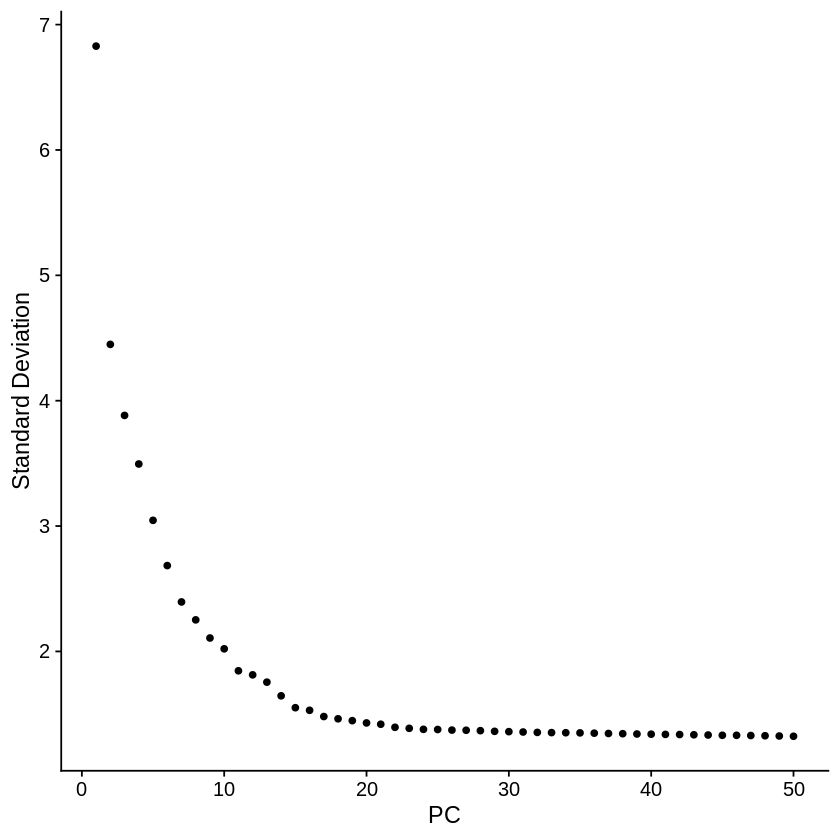

In [9]:
ElbowPlot(dataobj,100) 

## 下面要调

In [10]:
pcDim = 30
# Cluster the cells
dataobj2 <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj2 <- FindClusters(dataobj2, resolution = 1, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6443
Number of edges: 249826

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8343
Number of communities: 16
Elapsed time: 0 seconds


In [10]:
pcDim = 30
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.8, n.start = 10)

Computing nearest neighbor graph
Computing SNN


Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6443
Number of edges: 295283

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8447
Number of communities: 13
Elapsed time: 0 seconds


In [12]:
# Visulize the clustering result
dataobj3 <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"17:07:00 UMAP embedding parameters a = 0.9922 b = 1.112
17:07:00 Read 6443 rows and found 30 numeric columns
17:07:00 Using Annoy for neighbor search, n_neighbors = 30
17:07:00 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
17:07:01 Writing NN index file to temp file /tmp/RtmpADzt3t/file225973126f1
17:07:01 Searching Annoy index using 1 thread, search_k = 3000
17:07:03 Annoy recall = 100%
17:07:03 Commencing smooth kNN distance calibration using 1 thread
17:07:03 Initializing from normalized Laplacian + noise
17:07:04 Commencing optimization

In [11]:
# Visulize the clustering result
dataobj3 <- RunUMAP(dataobj2, dims = 1:pcDim)

ERROR: Error in RunUMAP(dataobj2, dims = 1:pcDim): object 'dataobj2' not found


In [13]:
p_umap <- DimPlot(dataobj3, reduction = "umap", label = TRUE, pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap, width = 8, height = 5)

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

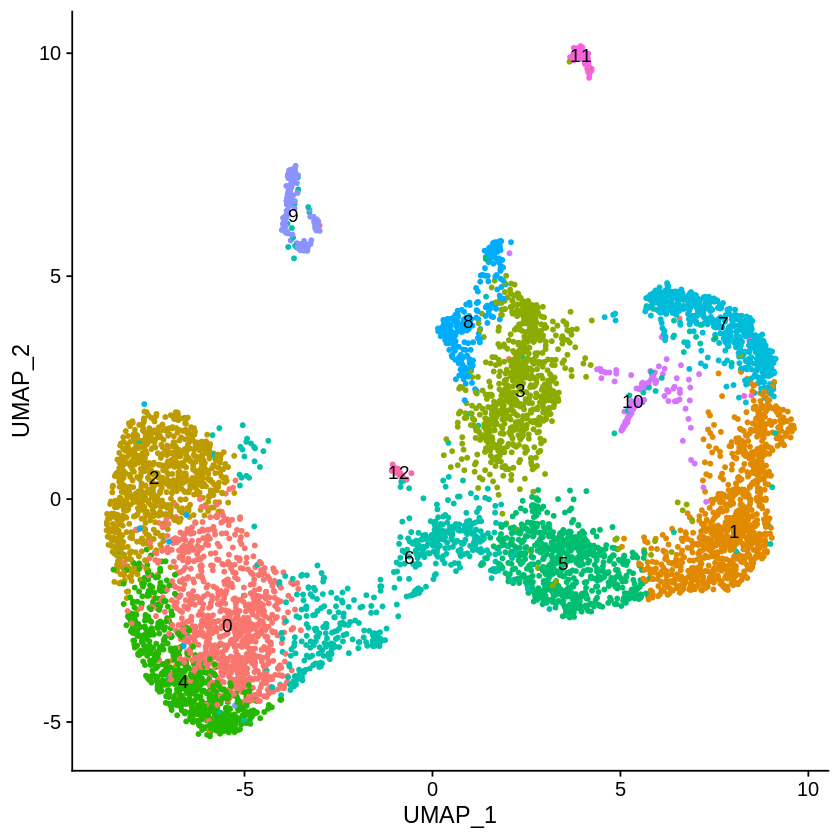

In [14]:
p_umap

In [15]:
p_umap2 <- DimPlot(dataobj3, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height =5)

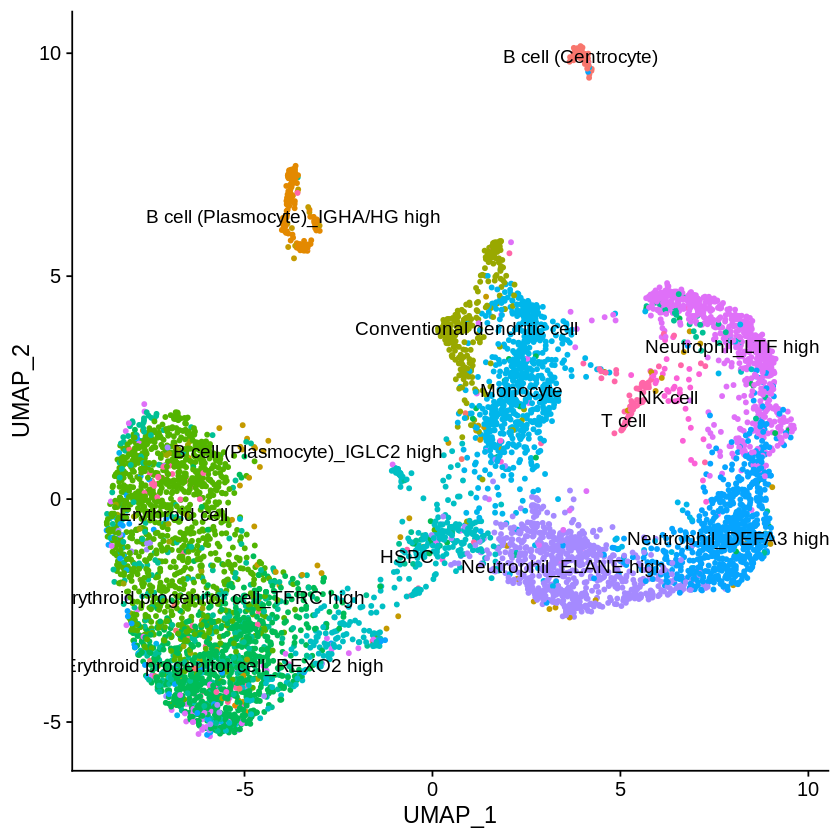

In [16]:
p_umap2

In [6]:

# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9


In [13]:
p_umap3

ERROR: Error in eval(expr, envir, enclos): object 'p_umap3' not found


In [ ]:



# Extract demo data for test
#data.matrix <- data.matrix[,1:500]
#data.metadata <- data.metadata[1:500,]
#data.annotation <- data.annotation[1:500,,drop=FALSE]



# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj) 
dev.off()
pcDim = 75 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 3, n.start = 10)

# Compare the seurat clusters with original clusters
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

# Visulize the clustering result
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1)
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    p_umap3 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_ontology_class", pt.size=1)
    ggsave(paste0(datasetName,".seurat.umap_cb.tiff"), plot = p_umap3, width = 8, height = 5)
}


# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))
